In [1]:
import xarray as xr
import numpy as np
import glob2 as glob
import functions
import os

### User input

In [2]:
rpath='/projects/NS9600K/astridbg/data/model/noresm_rawdata/cases/' # Provide path to model data
exp_idx = 3 # Choose case/experiment index
interval = 30 # Choose number of years in interval over which to calculate


caselist = ['N1850_f19_tn14_noresm2_3_slf_output_20250529', 
            'N1850_f19_tn14_noresm2_3_slf_output_0_5xCO2_20250529', 
            'N1850_f19_tn14_noresm2_3_slf_output_2xCO2_20250529', 
            'N1850_f19_tn14_noresm2_3_slf_output_4xCO2_20250529']

expnamelist = ['piClim', 
            'abrupt-0_5xCO2', 
            'abrupt-2xCO2', 
            'abrupt-4xCO2']

if interval == 30:

    tslicelist = [slice('1920-01-01', '1949-12-31'), slice('1950-01-01', '1979-12-31'),
                slice('1980-01-01', '2009-12-31'), slice('2010-01-01', '2039-12-31'),
                slice('2040-01-01', '2069-12-31')]
    
    slicenamelist = ['1920-01-01_1949-12-31', '1950-01-01_1979-12-31',
                '1980-01-01_2009-12-31', '2010-01-01_2039-12-31',
                '2040-01-01_2069-12-31']

elif interval == 15:

    tslicelist = [slice('1920-01-01', '1934-12-31'), slice('1935-01-01', '1949-12-31'),
                slice('1950-01-01', '1964-12-31'), slice('1965-01-01', '1979-12-31'),
                slice('1980-01-01', '1994-12-31'), slice('1995-01-01', '2009-12-31'),
                slice('2010-01-01', '2024-12-31'), slice('2025-01-01', '2039-12-31'),
                slice('2040-01-01', '2054-12-31'), slice('2055-01-01', '2069-12-31')]

    slicenamelist=['1920-01-01_1934-12-31','1935-01-01_1949-12-31',
                '1950-01-01_1964-12-31', '1965-01-01_1979-12-31',
                '1980-01-01_1994-12-31', '1995-01-01_2009-12-31',
                '2010-01-01_2024-12-31', '2025-01-01_2039-12-31',
                '2040-01-01_2054-12-31', '2055-01-01_2069-12-31']
    

elif interval == 10:

    tslicelist = [slice('1920-01', '1929-12'), slice('1930-01-01', '1939-12-31'),
              slice('1940-01-01', '1949-12-31'), slice('1950-01-01', '1959-12-31'),
              slice('1960-01-01', '1969-12-31'), slice('1970-01-01', '1979-12-31'),
              slice('1980-01-01', '1989-12-31'), slice('1990-01-01', '1999-12-31'),
              slice('2000-01-01', '2009-12-31'), slice('2010-01-01', '2019-12-31'),
              slice('2020-01-01', '2029-12-31'), slice('2030-01-01', '2039-12-31'),
              slice('2040-01-01', '2049-12-31'), slice('2050-01-01', '2059-12-31'),
              slice('2060-01-01', '2069-12-31')]

    slicenamelist = ['1920-01-01_1929-12-31','1930-01-01_1939-12-31',
               '1940-01-01_1949-12-31', '1950-01-01_1959-12-31',
               '1960-01-01_1969-12-31', '1970-01-01_1979-12-31',
               '1980-01-01_1989-12-31', '1990-01-01_1999-12-31',
               '2000-01-01_2009-12-31', '2010-01-01_2019-12-31',
               '2020-01-01_2029-12-31', '2030-01-01_2039-12-31',
               '2040-01-01_2049-12-31', '2050-01-01_2059-12-31',
               '2060-01-01_2069-12-31']
    
N = len(slicenamelist)
print('Number of intervals: '+str(N))

casename=caselist[exp_idx]
expname=expnamelist[exp_idx]
print(expname+': '+casename)

Number of intervals: 5
abrupt-4xCO2: N1850_f19_tn14_noresm2_3_slf_output_4xCO2_20250529


### Load data and fix time stamp

In [3]:
all_files = glob.glob(rpath+casename+"/atm/hist/"+casename+".cam.h0.*")
all_files.sort()
print("Files found")

ds_full = xr.open_mfdataset(all_files)
print("Dataset created")

# Fix timestamp of model data
ds_full = functions.fix_cam_time(ds_full)
print("First timestep after fix: ", ds_full.time[0].values)
print("Last timestep after fix: ", ds_full.time[-1].values)

Files found
Dataset created
First timestep after fix:  1920-01-15 00:00:00
Last timestep after fix:  2069-12-15 00:00:00


### Postprocess variables for cloud radiative kernel feedback analysis

In [4]:
wpath='/projects/NS9600K/astridbg/arctic-cld-feedbacks/data/feedback_input/' # Provide path to save data
os.makedirs(wpath, exist_ok=True) 

for time_idx in range(N):
    tslice=tslicelist[time_idx]
    slicename=slicenamelist[time_idx]
    print(slicename)

    # Create time slice of the data
    ds = ds_full.sel(time=tslice)

    # Rename NorESM2.3 variable and coordinates to CMIP6 standard
    print("CLISCCP")
    ds_r = ds.rename({'FISCCP1_COSP':'clisccp', 'cosp_prs':'plev', 'cosp_tau':'tau'})

    # Create new variable: upwelling SW flux at surface, with CMIP6 name
    print("Radiation")
    rsuscs_values = ds['FSDSC']-ds['FSNSC'] # Upwelling surface SW = Downwelling surface SW - net surface SW
    ds_r = ds_r.assign(rsuscs=rsuscs_values)

    # Rename NorESM2.3 variable to CMIP6 standard
    ds_r = ds_r.rename({'FSDSC':'rsdscs'})

    # Rename NorESM2.3 variable to CMIP6 standard
    ds_r = ds_r.rename({'TREFHT':'tas'})

    # Save variables
    for var in ['clisccp', 'rsuscs','rsdscs', 'tas']:
        print(var)
        ds_r[var].to_netcdf(wpath+'interval'+str(interval)+'/'+var+'_'+expname+'_'+slicename+'.nc')

print('Variables for feedback calculation postprocessed')

1920-01-01_1949-12-31
CLISCCP
Radiation
clisccp
rsuscs
rsdscs
tas
1950-01-01_1979-12-31
CLISCCP
Radiation
clisccp
rsuscs
rsdscs
tas
1980-01-01_2009-12-31
CLISCCP
Radiation
clisccp
rsuscs
rsdscs
tas
2010-01-01_2039-12-31
CLISCCP
Radiation
clisccp
rsuscs
rsdscs
tas
2040-01-01_2069-12-31
CLISCCP
Radiation
clisccp
rsuscs
rsdscs
tas
Variables for feedback calculation postprocessed


### Store other relevant variables

In [ ]:
wpath = '/projects/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/' # Provide path to save data
os.makedirs(wpath, exist_ok=True)

for var in ['CLOUD', 'Q', 'RELHUM', 'CLDICE', 'CLDLIQ', 'T', 'TH',
            'hyam', 'hybm', 'hyai', 'hybi', 'PS', 'P0', # for regridding
            'TGCLDLWP', 'TGCLDIWP','CLDTOT', 'ICEFRAC', 'LANDFRAC']:
    print(var)
    ds_full[var].to_netcdf(wpath+var+'_'+expname+'.nc')

In [4]:
wpath = '/projects/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/' # Provide path to save data
os.makedirs(wpath, exist_ok=True) 

#for var in ['TGCLDLWP', 'TGCLDIWP','CLDTOT', 'ICEFRAC', 'LANDFRAC']:
for var in ['CLDLOW']:
    print(var)
    ds_full[var].to_netcdf(wpath+var+'_'+expname+'.nc')

CLDLOW


# From here on out, the data is postprocessed step by step

### ... or do it one step at a time

In [ ]:
# Create time slice of the data
ds = ds_full.sel(time=tslice)
print(ds.time)

### CLISCCP

In [ ]:
# Rename NorESM2.3 variable and coordinates
print("Model data:")
ds_r = ds.rename({'FISCCP1_COSP':'clisccp', 'cosp_prs':'plev', 'cosp_tau':'tau'})
print(ds_r['clisccp'])

# Check that it corresponds with CMIP6 data
print("\nExample CMIP6 data:")
example_folder = "example_data/"
example_ds_clisccp = xr.open_dataset(example_folder+"clisccp_CFmon_E3SM-2-1_amip_r1i1p1f1_gr_197101-201412.nc")
print(example_ds_clisccp['clisccp'])

Model data:
<xarray.DataArray 'clisccp' (time: 180, plev: 7, tau: 7, lat: 96, lon: 144)> Size: 488MB
dask.array<getitem, shape=(180, 7, 7, 96, 144), dtype=float32, chunksize=(1, 7, 7, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * plev     (plev) float64 56B 9e+04 7.4e+04 6.2e+04 ... 2.45e+04 9e+03
  * tau      (tau) float64 56B 0.15 0.8 2.45 6.5 16.2 41.5 100.0
  * time     (time) object 1kB 1950-01-15 00:00:00 ... 1964-12-15 00:00:00
Attributes:
    mdims:         [7 6]
    units:         percent
    long_name:     Grid-box fraction covered by each ISCCP D level cloud type
    cell_methods:  time: mean

Example CMIP6 data:
<xarray.DataArray 'clisccp' (time: 528, tau: 7, plev: 7, lat: 180, lon: 360)> Size: 7GB
[1676505600 values with dtype=float32]
Coordinates:
  * time     (time) object 4kB 1971-01-16 12:00:00 ... 2014-12

### Radiation

In [ ]:
# Create new variable: upwelling SW flux at surface, with CMIP6 name
print("Model data:")
rsuscs_values = ds['FSDSC']-ds['FSNSC'] # Upwelling surface SW = Downwelling surface SW - net surface SW
ds_r = ds_r.assign(rsuscs=rsuscs_values)
print(ds_r['rsuscs'])

# Rename variable
ds_r = ds_r.rename({'FSDSC':'rsdscs'})
print(ds_r['rsdscs'])

# Check that it corresponds with CMIP6 data
print("\nExample CMIP6 data:")
example_folder = "/nird/projects/NS9600K/astridbg/arctic-cld-feedbacks/example_data/"
example_ds_rad = xr.open_mfdataset(example_folder+"r*")
print(example_ds_rad['rsuscs'])
print(example_ds_rad['rsdscs'])


Model data:
<xarray.DataArray 'rsuscs' (time: 180, lat: 96, lon: 144)> Size: 10MB
dask.array<sub, shape=(180, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 1kB 1950-01-15 00:00:00 ... 1964-12-15 00:00:00
<xarray.DataArray 'rsdscs' (time: 180, lat: 96, lon: 144)> Size: 10MB
dask.array<getitem, shape=(180, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 1kB 1950-01-15 00:00:00 ... 1964-12-15 00:00:00
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Clearsky downwelling solar flux at surface
   

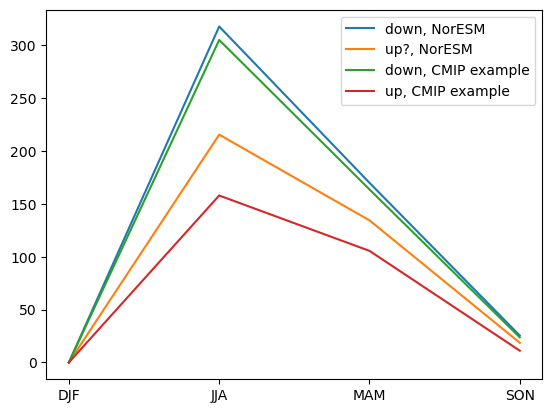

In [ ]:
# Visualize to double check that radiation fluxes was calculated correctly
import matplotlib.pyplot as plt

ds_r_s = ds_r.isel(lat=90, lon=0).groupby('time.season').mean('time')
plt.plot(ds_r_s.season, ds_r_s['rsdscs'], label='down, NorESM')
plt.plot(ds_r_s.season, ds_r_s['rsuscs'], label='up?, NorESM')

ds_e_s = example_ds_rad.isel(lat=90, lon=0).groupby('time.season').mean('time')
plt.plot(ds_e_s.season, ds_e_s['rsdscs'], label='down, CMIP example')
plt.plot(ds_e_s.season, ds_e_s['rsuscs'], label='up, CMIP example')

plt.legend()

### Temperature

In [ ]:
# Rename variable
ds_r = ds_r.rename({'TREFHT':'tas'})
print(ds_r['tas'])

<xarray.DataArray 'tas' (time: 180, lat: 96, lon: 144)> Size: 10MB
dask.array<getitem, shape=(180, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 1kB 1950-01-15 00:00:00 ... 1964-12-15 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean


### Save variables

### Check that the variables are opened correctly

In [ ]:
print(wpath)
for var in ['clisccp', 'rsuscs','rsdscs', 'tas']:
    ds = xr.open_mfdataset(wpath+var+'_'+expname+'_*12-31.nc')
    print(ds)

/projects/NS9600K/astridbg/arctic-cloud-feedbacks/data/


OSError: no files to open

In [ ]:
print(list(ds_full.variables)[38:])
for var in list(ds_full.variables)[38:]:
    print(var+' '+ds_full[var].long_name)